## Imports

In [1]:
%%time
'''
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot as plt
from scipy.signal    import find_peaks
from scipy.integrate import simps, trapz
'''

from mainFile import *

mainFile e bibliotecas importados
Wall time: 1.59 s


# Lendo arquivo das waveforms

#### O arquivo original já foi parcialmente modificado em relação a linhas e colunas

In [2]:
%%time
'''Lendo arquivo das waveforms'''

waveform = pd.read_csv(
    'data/5555_eventos-edit.csv', 
    index_col = 0
                      ) # importa como waveform vs sample
# waveform

Wall time: 3.49 s


In [3]:
#plt.plot( waveform.time, waveform.event_0 )
#waveform.shape[1] - 1

# 3. Análise de dados

## 3.1. Copia o data frame e seleciona a janela de busca

Cria uma cópia das waveforms para poder transladar o base line sem modificar os dados originais;

Define a janela onde procuraremos pelos valores do contorno do pulso

In [4]:
df = waveform.copy(deep = True)
df = df.iloc[ : , :df.shape[1] - 1 ]

VA_1 = 20 # VA_1 e VA_2 são variáveis arbitrárias para definir o majorante da largura dos pulsos
VA_2 = 70

convert_to_microsec = 1/250

df.head()

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5545,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554
0,56.0,56.0,56.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,54.0,54.0,53.0,53.0,51.0,51.0,51.0,51.0,51.0,51.0
1,55.0,55.0,55.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,52.0,52.0,52.0,52.0,52.0,51.0,51.0,51.0,51.0,51.0
2,53.0,53.0,53.0,51.0,53.0,53.0,55.0,55.0,55.0,55.0,...,53.0,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0
3,53.0,53.0,53.0,52.0,53.0,53.0,54.0,54.0,54.0,54.0,...,53.0,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0
4,54.0,54.0,54.0,53.0,55.0,55.0,55.0,55.0,55.0,55.0,...,51.0,51.0,53.0,53.0,52.0,54.0,54.0,54.0,54.0,54.0


## 3.2. Translação da base-line

É interessante transladar os pontos e fixar a base line no 0. Podemos fazer isso somando ~= -50 em cada um dos valores de toda a coleção de waveforms. Isso servirá para evitar problemas de 'height' no peak_finder()

Análise estatística do base-line:
No caso, tomaremos todos os dados antes do primeiro pulso de cada waveform e consideraremos o base-line como o mesmo para todos os waveforms

#### Método:

Para encontrar a base line, selecionaremos a parte mais à esquerda, antes do pulso. 
Esse pedaço é definido como fora de um valor arbitrário em torno do primeiro pico da waveform, que acaba não sofrendo com a questão da base line. Definimos desse jeito porque a função para calcular o contorno do pulso, além de demorar para ser computada, sofre com as questões do peak_finder acabar encontrando apenas um elemento


In [5]:
%%time

height = 50 # esse parâmetro aqui é somente para efeito de encontrar os elementos da  base line a priori

baseLines = baseLine(df, height = height, VA_1 = VA_1)

Wall time: 1.8 s


In [6]:
# baseLines

In [7]:
# baseLines.value_counts()

In [8]:
baseLines.mean() , baseLines.std()

(52.27678966421793, 3.159833572851221)

#### Relocação do base-line
Colocando o valor médio do base line como o parâmetro height do peak-finder, surpreendentemente temos um resultado que não incorre em erros na hora de achar os dois picos de cada waveform. No caso, ele acaba por achar dois picos (não mais nem menos) de maneira mais fácil e exata

In [9]:
'''
Alterando os valores e recolocando na base line ~= 0
'''

df.iloc[ :  , : waveform.shape[1] ] -= baseLines.mean() 
# soma ~= -50 em todo o df, exceto pela última coluna 'time'
df.head()

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5545,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554
0,3.72321,3.72321,3.72321,0.72321,2.72321,2.72321,1.72321,1.72321,1.72321,1.72321,...,1.72321,1.72321,0.72321,0.72321,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679
1,2.72321,2.72321,2.72321,0.72321,2.72321,2.72321,1.72321,1.72321,1.72321,1.72321,...,-0.27679,-0.27679,-0.27679,-0.27679,-0.27679,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679
2,0.72321,0.72321,0.72321,-1.27679,0.72321,0.72321,2.72321,2.72321,2.72321,2.72321,...,0.72321,0.72321,0.72321,0.72321,-2.27679,2.72321,2.72321,2.72321,2.72321,2.72321
3,0.72321,0.72321,0.72321,-0.27679,0.72321,0.72321,1.72321,1.72321,1.72321,1.72321,...,0.72321,0.72321,0.72321,0.72321,-2.27679,2.72321,2.72321,2.72321,2.72321,2.72321
4,1.72321,1.72321,1.72321,0.72321,2.72321,2.72321,2.72321,2.72321,2.72321,2.72321,...,-1.27679,-1.27679,0.72321,0.72321,-0.27679,1.72321,1.72321,1.72321,1.72321,1.72321


# 4. Preparação dos dados para o plot
Selecionamos os picos, no eixo y, em cada pulso e plotamos um histograma

## 4.1. Loop para construção e check do peak_finder
Esse loop cria e checa se existem erros na obtenção dos picos através da função peak-finder, quando peaks != 2

In [10]:
%%time

height = baseLines.mean()

_ = peaks_divididos_01(df, height = baseLines.mean())

peaks_xy_0   ,   peaks_xy_1   =   _[0]   ,   _[1]

não foram detectados problemas na quantidade de picos
Wall time: 3.1 s


## 4.2. Histograma com os valores de diferença de tempo

In [11]:
_ = pd.DataFrame(   
    peaks_em_x(df, height=baseLines.mean()),  
    columns = ['peak_0', 'peak_1']   
                )
   
delta_x = (   _['peak_1']  -  _['peak_0']   )
delta_x.name = 'delta_x'


loop finalizado com 0 erros


Desenha o histograma

In [12]:
#sns.histplot(delta_x*convert_to_microsec)
#plt.title('Diferenças de tempo entre o primeiro e o segundo pulso')
#plt.xlabel('Diferença de tempo (micro seg)')

## 4.3. Ajuste da curva exponencial

In [13]:
'''
Definimos a função de ajuste para a exponencial
'''

def fit_function(t, A, tau, C): # função de ajuste exponencial
    return(  A * np.e**(-t/tau) + C  )

(b) Coletamos os dados e fazemos plots preliminares, para ir acompanhando os resultados


Obs.: a variável number_of_bins é o jeito padrão de quantificar quantos bins se tem num histograma

fonte: https://stackoverflow.com/questions/60512271/how-can-i-extract-the-bins-from-seaborns-kde-distplot-object

In [14]:
'''
Coletando os dados do histograma para o plot
'''
number_of_bins     = min(  len( np.histogram_bin_edges(delta_x, bins="fd") ), 50  )
data_entries, bins = np.histogram(delta_x , bins = number_of_bins)
bins_centers       = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

(c) Fazemos a regressão pela curve_fit do Scipy

obs.: É importante dar um valor inicial para os parâmetros, como um chute inicial. Nesse caso, eu apenas chutei os valores mesmo algumas vezes

In [15]:
p0 = np.array([ 0.5, 10, 1 ]) # initial guess for the parameters: y(t) = A * np.e**(-t/tau) + C
opt_coeff, cov_coeff = curve_fit(  fit_function , xdata = bins_centers , ydata = data_entries, p0 = p0  )

(d) Plot com histograma e regressão da curva

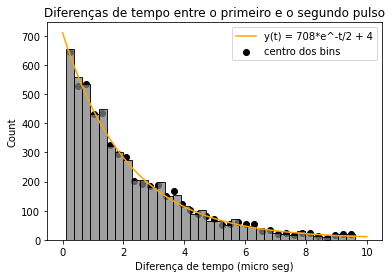

In [16]:
# converter os resultados para as unidades corretas
coeff = np.array([ opt_coeff[0], opt_coeff[1]*convert_to_microsec, opt_coeff[2] ])

# plot do histograma
sns.histplot(delta_x*convert_to_microsec, color='gray')

# plot dos centros dos bins
plt.scatter(bins_centers*convert_to_microsec, data_entries, color = 'black', label = 'centro dos bins')

# plot da curve_fit
x = np.linspace(0,10, 10000)
plt.plot( 
    x, fit_function(x, coeff[0], coeff[1], coeff[2]), 
    color = 'orange', label = f'y(t) = {round(coeff[0])}*e^-t/{round(coeff[1])} + {round(coeff[2])}' )

# detalhes
plt.title('Diferenças de tempo entre o primeiro e o segundo pulso')
plt.xlabel('Diferença de tempo (micro seg)')
plt.legend()
plt.savefig('data/curve_fit-vida_media')

(e) incertezas



In [17]:
#cov_coeff.round()

In [18]:
'''
Calcula a incerteza
'''
coeff_std   = np.sqrt(np.diag(cov_coeff)) #"sigma"
coeff_error = coeff_std / np.sqrt(number_of_bins - 1) #"sigma / sqrt(n)"

'''
Converte a incerteza do tau para micro seg
'''
coeff_error[1] = coeff_error[1]*convert_to_microsec

'''
Resultado
'''
coeff_error

array([2.33935527, 0.01592518, 1.11537637])

In [19]:
coeff_results = pd.DataFrame( [coeff, coeff_error] ).T
coeff_results.rename( columns = {0:'valor', 1:'incerteza'}, index ={ 0:'A', 1:'tau', 2:'C' } , inplace = True )
coeff_results

,valor,incerteza
A,707.655718,2.339355
tau,2.143807,0.015925
C,3.960233,1.115376


## 4.2. Filtrando os dados de acordo com o valor do tempo de vida do muon

In [20]:
delta_x_filtrado = delta_x.where(delta_x <= 5*250).dropna()
#delta_x_filtrado

Redefinimos o df original para agora ser esse filtrado

In [21]:
df_filtrado = df.iloc[: , delta_x_filtrado.index]
df_filtrado.head()

,event_0,event_1,event_2,event_3,event_10,event_11,event_12,event_13,event_14,event_15,...,event_5539,event_5540,event_5541,event_5542,event_5543,event_5545,event_5546,event_5547,event_5548,event_5549
0,3.72321,3.72321,3.72321,0.72321,0.72321,2.72321,0.72321,0.72321,-0.27679,0.72321,...,1.72321,-1.27679,-1.27679,-0.27679,-0.27679,1.72321,1.72321,0.72321,0.72321,-1.27679
1,2.72321,2.72321,2.72321,0.72321,2.72321,-0.27679,0.72321,0.72321,-0.27679,1.72321,...,0.72321,0.72321,0.72321,-1.27679,-1.27679,-0.27679,-0.27679,-0.27679,-0.27679,-0.27679
2,0.72321,0.72321,0.72321,-1.27679,-1.27679,0.72321,1.72321,1.72321,0.72321,-0.27679,...,-0.27679,1.72321,1.72321,-2.27679,-2.27679,0.72321,0.72321,0.72321,0.72321,-2.27679
3,0.72321,0.72321,0.72321,-0.27679,-1.27679,-0.27679,1.72321,1.72321,0.72321,1.72321,...,-1.27679,0.72321,0.72321,-2.27679,-2.27679,0.72321,0.72321,0.72321,0.72321,-2.27679
4,1.72321,1.72321,1.72321,0.72321,-0.27679,0.72321,-0.27679,-0.27679,1.72321,-2.27679,...,-1.27679,-3.27679,-3.27679,-0.27679,-0.27679,-1.27679,-1.27679,0.72321,0.72321,-0.27679


# 5. Plot espectro de amplitude

## 5.1. Plot do espectro de amplitude do primeiro pulso 

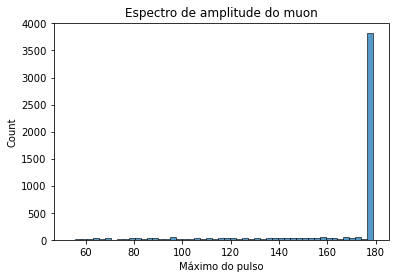

In [22]:
sns_plot = sns.histplot( -1*peaks_xy_0['y'].round() )
plt.title('Espectro de amplitude do muon')
plt.xlabel('Máximo do pulso')
plt.savefig("images/espectro_amplitude-pulso_0.png", dpi = 150)

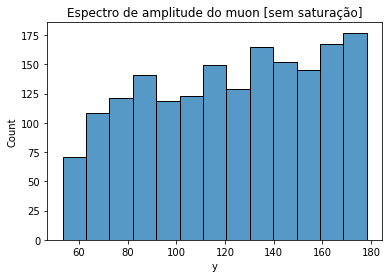

In [23]:
sns_plot = sns.histplot( -1*peaks_xy_0.query('y > y.min()')['y'] )
plt.title('Espectro de amplitude do muon [sem saturação]')
plt.savefig("images/espectro_amplitude_0_ZOOM.png", dpi = 150)

In [24]:
# peaks_xy_0['y'].round().value_counts() #original

In [25]:
# peaks_xy_0.query('y > y.min()')['y'] #sem saturação

## 5.3. Plot do espectro de amplitude do segundo pulso 

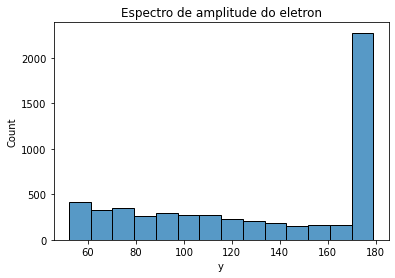

In [26]:
sns.histplot( -1*peaks_xy_1['y'].round() )
plt.title('Espectro de amplitude do eletron')
plt.savefig("images/espectro_amplitude_1.png", dpi = 150)

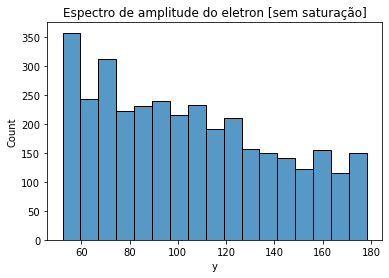

In [27]:
sns.histplot( -1*peaks_xy_1.query('y > y.min()')['y'] )
plt.title('Espectro de amplitude do eletron [sem saturação]')
plt.savefig("images/espectro_amplitude_1_ZOOM.png", dpi = 150)

In [28]:
#-1*peaks_1.query('y > y.min()').y

In [29]:
#peaks_1.y.round().value_counts()

# 6. Plot dos espectro de carga

## 6.2. Integração do pulso 

Integramos o pulso para obter a carga gerada com ele. Utilizamos a integração pelo método de Simpson.

In [30]:
%%time

_ = contorno_limite_arbitrario(df, VA_1, VA_2, baseLines.mean(), check=0)

integrais_0 = integral_simples_dataframe(_[0], dx=1)
integrais_1 = integral_simples_dataframe(_[1], dx=1)

não foram detectados problemas na quantidade de picos

Foram detectados 21 problemas na questão do tamanho da janela do contorno;
Os problemas estão em [6, 7, 8, 9, 213, 608, 1821, 2277, 2509, 3310, 3612, 3613, 3614, 3615, 3616, 4301, 4397, 4398, 4399, 4572, 5427];
Preenchidos com valores Nan

Wall time: 18.7 s


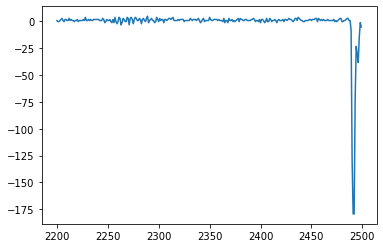

In [31]:
plt.plot(df.event_6.iloc[2200:2500])

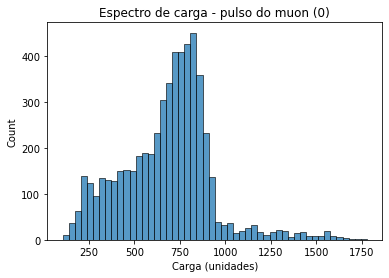

In [32]:
sns.histplot(-1*integrais_0)
plt.title("Espectro de carga - pulso do muon (0)")
plt.xlabel('Carga (unidades)')
plt.savefig("images/espectro_carga-pulso_0.png", dpi = 150)

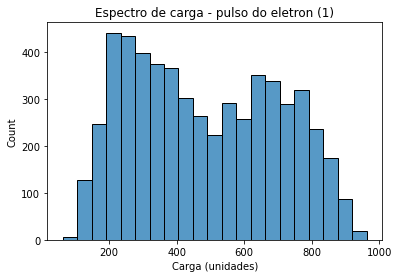

In [33]:
sns.histplot(-1*integrais_1)
plt.title("Espectro de carga - pulso do eletron (1)")
plt.xlabel('Carga (unidades)')
plt.savefig("images/espectro_carga-pulso_1.png", dpi = 150)

Trabalhar no código para o plot filtrando fora os eventos saturados

Como pedido, um DataFrame que une os valores dos delta_t, picos e integrais

In [34]:
_ = pd.DataFrame( [delta_x , -1*integrais_0 , -1*integrais_1] ).T

df_bruto = pd.concat( (_ , peaks_xy_0.reset_index().iloc[: , 1:], peaks_xy_1.reset_index().iloc[: , 1:]) , axis=1)
df_bruto.columns = ['delta_x' , 'integrais_muon' , 'integrais_eletron', 'x_pico_muon' , 'y_pico_muon', 'x_pico_eletron' , 'y_pico_eletron']

df_bruto

,delta_x,integrais_muon,integrais_eletron,x_pico_muon,y_pico_muon,x_pico_eletron,y_pico_eletron
0,1017.0,547.187859,496.187859,94,-179.27679,1111,-179.27679
1,1017.0,547.187859,496.187859,94,-179.27679,1111,-179.27679
2,1017.0,547.187859,496.187859,94,-179.27679,1111,-179.27679
3,228.0,605.187859,757.187859,94,-179.27679,322,-179.27679
4,1721.0,617.187859,157.187859,94,-179.27679,1815,-84.27679
...,...,...,...,...,...,...,...
5550,1643.0,164.187859,875.187859,93,-56.27679,1736,-179.27679
5551,1643.0,164.187859,875.187859,93,-56.27679,1736,-179.27679
5552,1643.0,164.187859,875.187859,93,-56.27679,1736,-179.27679
5553,1643.0,164.187859,875.187859,93,-56.27679,1736,-179.27679


In [35]:
df_bruto.to_csv('df_resultados_brutos.csv')